In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import erf

In [3]:
data1 = pd.read_csv('../prices/prices_round_4_day_1.csv', header = 0, sep=";")
data2 = pd.read_csv('../prices/prices_round_4_day_2.csv', header = 0, sep=";")
data3 = pd.read_csv('../prices/prices_round_4_day_3.csv', header = 0, sep=";")

# Join rows of data1, data2 and data3
data = pd.concat([data1, data2, data3])
data = data.reset_index(drop=True) # Reset indices
data.head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,1,0,COCONUT,9999.0,200.0,NaN,NaN,NaN,NaN,10001,200,NaN,NaN,NaN,NaN,10000.0,0.0
1,1,0,COCONUT_COUPON,637.0,39.0,NaN,NaN,NaN,NaN,638,39,NaN,NaN,NaN,NaN,637.5,0.0
2,1,100,COCONUT,9999.0,104.0,9998.0,44.0,NaN,NaN,10000,104,10001.0,44.0,NaN,NaN,9999.5,0.0
3,1,100,COCONUT_COUPON,637.0,33.0,NaN,NaN,NaN,NaN,638,33,NaN,NaN,NaN,NaN,637.5,0.0
4,1,200,COCONUT,9998.0,133.0,9997.0,62.0,NaN,NaN,9999,133,10000.0,62.0,NaN,NaN,9998.5,0.0


In [4]:
bid_ask_spread = data['ask_price_1'] - data['bid_price_1']
print(f"Mean bid-ask spread: {bid_ask_spread.mean()}")

Mean bid-ask spread: 1.2808260275342511


In [5]:
coconut_prices = data[data['product'] == 'COCONUT']['mid_price'].values
coupon_prices = data[data['product'] == 'COCONUT_COUPON']['mid_price'].values
print(f"Length of coupon: {len(coconut_prices)}, std: {np.std(coconut_prices)}, std adjusted for daily: {np.std(coconut_prices) / np.sqrt(10000)}")
# Volatility of the log returns of coconut prices
coconut_log_returns = np.log(coconut_prices[1:] / coconut_prices[:-1])
coconut_log_returns = np.abs(coconut_log_returns)
coconut_log_returns = coconut_log_returns[~np.isnan(coconut_log_returns)]
coconut_log_returns = coconut_log_returns[~np.isinf(coconut_log_returns)]
print(f"Length of log returns: {len(coconut_log_returns)}, std: {np.std(coconut_log_returns)}, std adjusted for daily: {np.std(coconut_log_returns) * np.sqrt(10000)}")

Length of coupon: 30000, std: 88.75266514702373, std adjusted for daily: 0.8875266514702373
Length of log returns: 29999, std: 6.464420407779463e-05, std adjusted for daily: 0.006464420407779463


In [6]:
def CDF_normal(x):
        return 0.5 * (1 + erf(x / np.sqrt(2)))

def calculate_black_scholes(S, sigma = 0.010119, r = 0, T = 246, K = 10000):
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return S * CDF_normal(d1) - K * np.exp(-r * T) * CDF_normal(d2)

In [11]:
historic_mean = 637.63
number = 0.010201
while True:
    number +=  0.00000000001
    if calculate_black_scholes(1e4, number) > historic_mean:
        print(f"sigma: {number}")
        break

sigma: 0.010201268450022212


In [8]:
calculate_black_scholes(10000, number)

637.630034375411

In [9]:
black_scholes_prices = np.array([calculate_black_scholes(x) for x in coconut_prices])

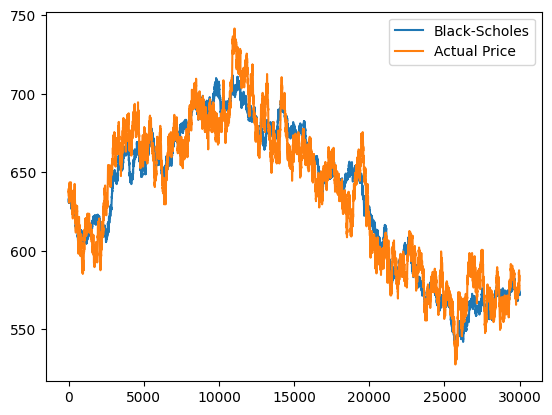

MSE: 183.86882875232482


In [10]:
plt.plot(black_scholes_prices, label='Black-Scholes')
plt.plot(coupon_prices, label='Actual Price')
plt.legend()
plt.show()
mse = np.mean((black_scholes_prices - coupon_prices) ** 2)
print(f"MSE: {mse}")
